# Clasificación de Riesgo de Asteroides (Sin MOID ni H)

Se entrena un modelo de Random Forest y una Red Neuronal excluyendo las variables MOID y H para evaluar la capacidad de predicción con información orbital limitada.

# Adquisición de Datos
Se obtienen datos de la API de la NASA SBDB. En este experimento se excluyen deliberadamente MOID y H para simular condiciones de observación temprana.

In [49]:
# IMPORTACIÓN DE LIBRERÍAS CIENTÍFICAS
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Librería para Explicabilidad (eXplainable AI)

# Scikit-Learn (Modelado Estadístico)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, recall_score, fbeta_score, make_scorer
)
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight

# TensorFlow (Redes Neuronales)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de Gráficos
sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (12, 6)
print("Entorno de investigación inicializado.")

Entorno de investigación inicializado.


In [50]:
def get_nasa_asteroid_data(limit=50000, save_path="asteroids_data.csv"):
    """
    Módulo de Ingesta de Datos: Conexión API NASA SBDB.
    Implementa caché local para eficiencia en la investigación.
    """
    if os.path.exists(save_path):
        print(f"Cargando dataset local: {save_path}")
        return pd.read_csv(save_path)
    
    print(f"📡 [API] Conectando a NASA JPL (Solicitando {limit} registros)...")
    url = "https://ssd-api.jpl.nasa.gov/sbdb_query.api"
    params = {
        "fields": "full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,moid,pha",
        "sb-group": "neo",
        "limit": limit,
        "full-prec": "true"
    }

    try:
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data['data'], columns=data['fields'])
        df.to_csv(save_path, index=False)
        print(f"Dataset generado: {len(df)} registros.")
        return df

    except Exception as err:
        print(f"[ERROR] Fallo en conexión API: {err}")
        return None

df_raw = get_nasa_asteroid_data()

# --- VISTA PREVIA DEL DATASET ---
print("\n VISTA PREVIA DEL DATASET:")
pd.set_option('display.max_columns', None)
display(df_raw.head())

Cargando dataset local: asteroids_data.csv

 VISTA PREVIA DEL DATASET:


,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,moid,pha
0,433 Eros (A898 PA),1.458121,0.222836,10.828467,304.270103,178.929754,1.133199,1.783043,1.760753,46582.0,0.0,9130,10.38,0.148353,N
1,719 Albert (A911 TB),2.636590,0.546596,11.573111,183.860972,156.189404,1.195441,4.077740,4.281266,41449.0,0.0,2111,15.59,0.201318,N
2,887 Alinda (A918 AA),2.473629,0.571170,9.400060,110.405876,350.534501,1.060766,3.886491,3.890541,39281.0,0.0,5880,13.81,0.079677,N
3,1036 Ganymed (A924 UB),2.664969,0.533213,26.680736,215.441191,132.503117,1.243972,4.085966,4.350572,36982.0,0.0,12915,9.18,0.343339,N
4,1221 Amor (1932 EA1),1.919831,0.434632,11.868823,171.237188,26.758225,1.085411,2.754252,2.660130,33947.0,0.0,686,17.37,0.107969,N


## Preprocesamiento y Análisis Exploratorio (EDA)

Se limpian los datos, se imputan valores faltantes y se codifica la variable objetivo, manteniendo la integridad de las variables orbitales puras.

C:\Users\gonza\AppData\Local\Temp\ipykernel_9004\1494051838.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='pha_binary', data=df_proc, palette='viridis')


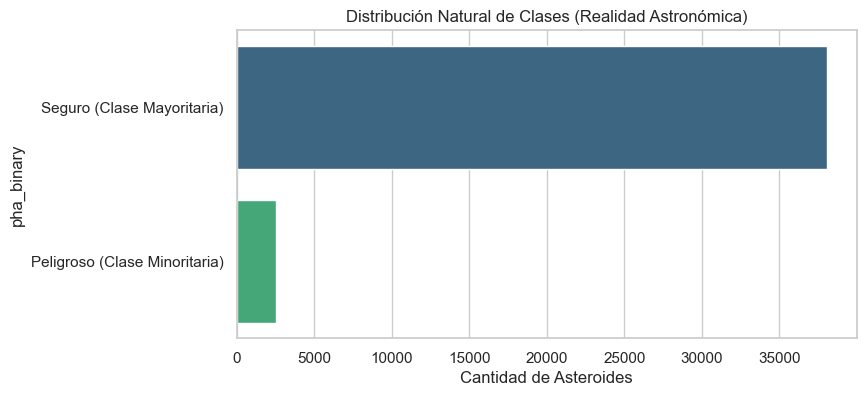

Desbalance: 93.76% Seguros vs 6.24% Peligrosos


In [51]:
def preprocess_data(df):
    df_clean = df.copy()
    
    # Conversión de tipos
    cols_numeric = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'n_obs_used', 'H', 'moid', 'condition_code']
    for col in cols_numeric:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Target Encoding
    df_clean['pha_binary'] = df_clean['pha'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

    # Filtrado de Calidad
    df_clean = df_clean.dropna(subset=['moid', 'H', 'a', 'e', 'i'])

    # Imputación Estadística
    imputer = SimpleImputer(strategy='median')
    if cols_numeric:
        df_clean[cols_numeric] = imputer.fit_transform(df_clean[cols_numeric])

    return df_clean

df_proc = preprocess_data(df_raw)

# Visualización del Desbalance
plt.figure(figsize=(8, 4))
sns.countplot(y='pha_binary', data=df_proc, palette='viridis')
plt.title('Distribución Natural de Clases (Realidad Astronómica)')
plt.yticks([0, 1], ['Seguro (Clase Mayoritaria)', 'Peligroso (Clase Minoritaria)'])
plt.xlabel('Cantidad de Asteroides')
plt.show()

ratio = df_proc['pha_binary'].value_counts(normalize=True)
print(f"Desbalance: {ratio[0]*100:.2f}% Seguros vs {ratio[1]*100:.2f}% Peligrosos")

## Balanceo con Pesos de Clase y Selección de Features

Se utilizan pesos de clase para compensar el desbalance y se eliminan explícitamente las columnas `moid` y `H` del conjunto de entrenamiento.

In [52]:
# Selección de Características (SIN MOID NI H)
features = ['a', 'e', 'i', 'om', 'w', 'q', 'condition_code', 'n_obs_used']
print("\n SIN VARIABLES CRÍTICAS: Excluyendo MOID y H del dataset.")
print(f"Variables utilizadas: {features}")

X = df_proc[features]
y = df_proc['pha_binary']

# División Estratificada (80% Entrenamiento / 20% Validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalado de Variables (Normalización Z-Score)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cálculo de Pesos de Clase
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print(f"Muestras originales: {len(y_train)}")
print(f"Pesos de Clase Calculados: {class_weights_dict}")


 SIN VARIABLES CRÍTICAS: Excluyendo MOID y H del dataset.
Variables utilizadas: ['a', 'e', 'i', 'om', 'w', 'q', 'condition_code', 'n_obs_used']
Muestras originales: 32488
Pesos de Clase Calculados: {0: np.float64(0.5332545466482831), 1: np.float64(8.0177690029615)}


## Modelado Computacional

Se entrenan modelos Random Forest y Red Neuronal utilizando el conjunto de características reducido y pesos de clase para ajustar la sensibilidad.

In [53]:
# ---  RANDOM FOREST ---
print("Entrenando Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, 
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)

# --- RED NEURONAL PROFUNDA ---
print("Entrenando Perceptrón Multicapa (MLP)...")
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks para optimización
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_nn.fit(
    X_train_scaled, y_train,
    epochs=50, batch_size=64,
    validation_split=0.2, callbacks=[early_stop], verbose=0,
    class_weight=class_weights_dict
)
print("Entrenamiento de modelos finalizado.")

Entrenando Random Forest Classifier...
Entrenando Perceptrón Multicapa (MLP)...


c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entrenamiento de modelos finalizado.



Generando Curva de Aprendizaje para Random Forest...


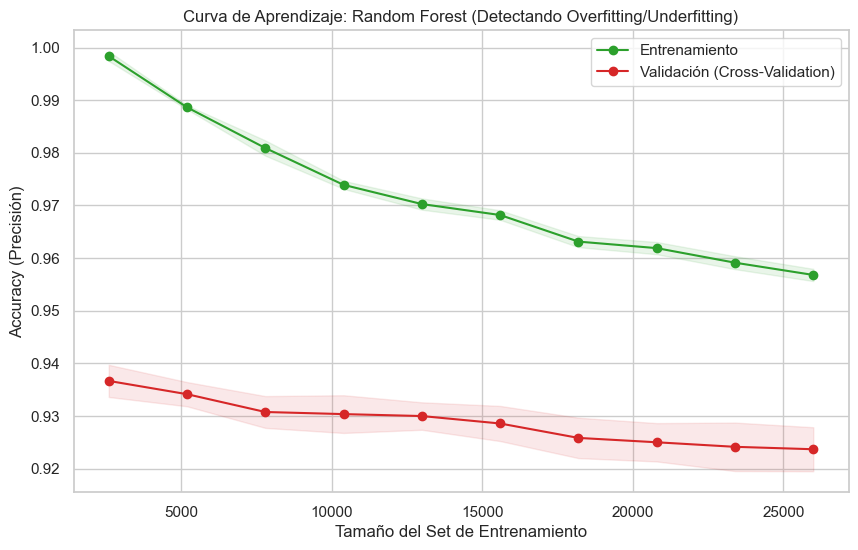

In [54]:
# --- CURVA DE APRENDIZAJE RANDOM FOREST ---
print("\nGenerando Curva de Aprendizaje para Random Forest...")
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="#2ca02c", label="Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="#d62728", label="Validación (Cross-Validation)")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="#2ca02c")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="#d62728")

plt.title("Curva de Aprendizaje: Random Forest (Detectando Overfitting/Underfitting)")
plt.xlabel("Tamaño del Set de Entrenamiento")
plt.ylabel("Accuracy (Precisión)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Diagnóstico de Entrenamiento

Se monitorea la curva de pérdida para asegurar la convergencia del modelo neuronal sin las variables dominantes.

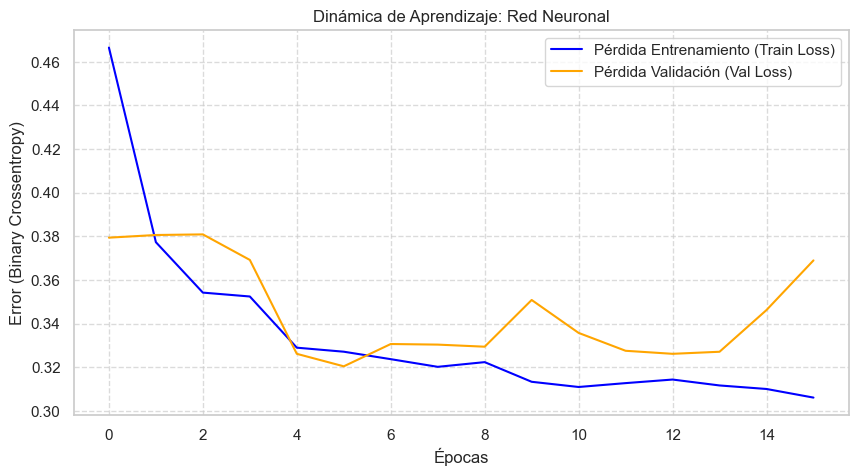

In [55]:
if 'history' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento (Train Loss)', color='blue')
    plt.plot(history.history['val_loss'], label='Pérdida Validación (Val Loss)', color='orange')
    plt.title('Dinámica de Aprendizaje: Red Neuronal')
    plt.ylabel('Error (Binary Crossentropy)')
    plt.xlabel('Épocas')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("La variable 'history' no está disponible.")

## Evaluación de Desempeño

Se mide la eficacia de los modelos en ausencia de MOID y H utilizando métricas de clasificación estándar y matrices de confusión.


  EVALUACIÓN: Random Forest

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7615
           1       0.43      0.68      0.53       507

    accuracy                           0.92      8122
   macro avg       0.71      0.81      0.75      8122
weighted avg       0.94      0.92      0.93      8122



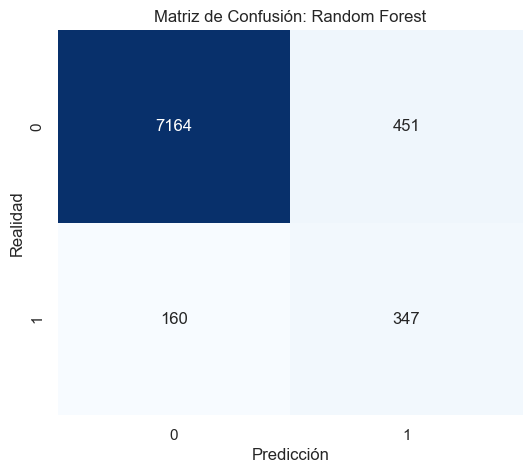

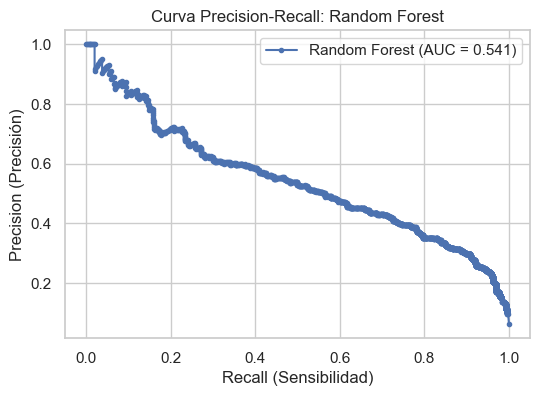


  EVALUACIÓN: Red Neuronal

254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7615
           1       0.27      0.92      0.42       507

    accuracy                           0.84      8122
   macro avg       0.63      0.88      0.66      8122
weighted avg       0.95      0.84      0.88      8122



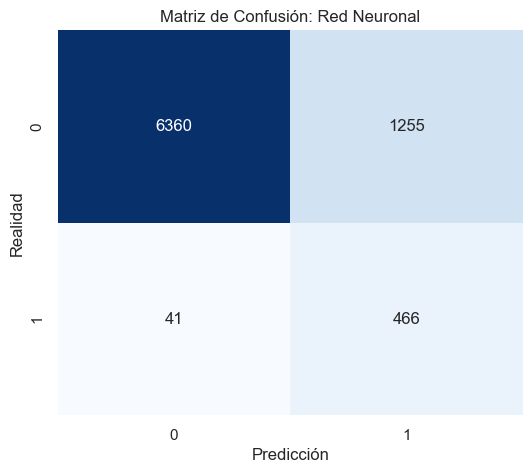

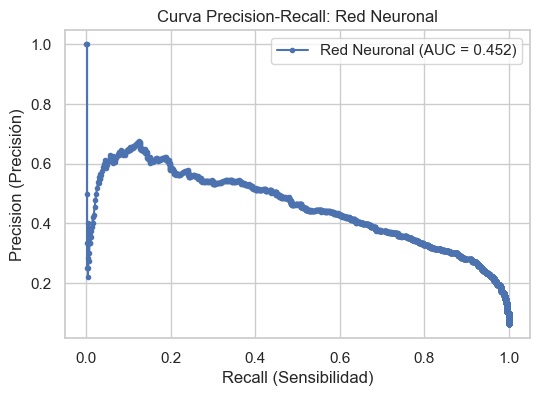

In [56]:
def evaluate_model(model, X_test, y_test, model_name="Modelo", is_nn=False):
    print(f"\n{'='*40}")
    print(f"  EVALUACIÓN: {model_name}")
    print(f"{'='*40}\n")

    # Predicciones
    if is_nn:
        y_prob = model.predict(X_test).ravel()
        y_pred = (y_prob > 0.5).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    # Métricas
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.show()

    # Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall (Sensibilidad)')
    plt.ylabel('Precision (Precisión)')
    plt.title(f'Curva Precision-Recall: {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return y_prob

# Evaluar ambos modelos
probs_rf = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")
probs_nn = evaluate_model(model_nn, X_test_scaled, y_test, "Red Neuronal", is_nn=True)

## Explicabilidad del Modelo (XAI)

Se utiliza SHAP para analizar qué variables orbitales asumen la importancia predictiva cuando MOID y H no están presentes.


🔍 Calculando valores SHAP para interpretabilidad (puede tardar un momento)...
SHAP devolvió un array de forma: (100, 8, 2)


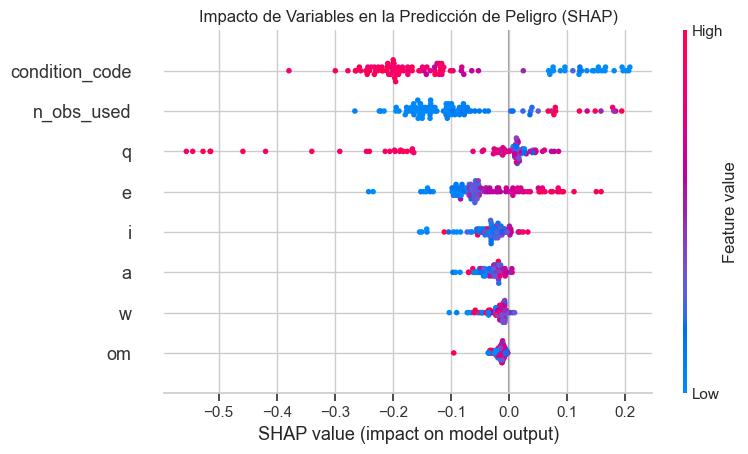

In [57]:
print("\n🔍 Calculando valores SHAP para interpretabilidad (puede tardar un momento)...")

# Usamos un muestreo del set de prueba para acelerar el cálculo
X_test_sample = pd.DataFrame(X_test_scaled, columns=features).sample(100, random_state=42)

# Explainer para Random Forest (TreeExplainer es optimizado para árboles)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# --- CORRECCIÓN DE DIMENSIONES SHAP ---
# Manejo robusto de la estructura de shap_values (puede variar según versión de sklearn/shap)
shap_vals_target = None

if isinstance(shap_values, list):
    # Caso Binario/Multiclase: Lista de arrays. Índice 1 suele ser la clase positiva.
    print(f"SHAP devolvió una lista de {len(shap_values)} matrices.")
    shap_vals_target = shap_values[1]
elif isinstance(shap_values, np.ndarray):
    # Caso Array único
    print(f"SHAP devolvió un array de forma: {shap_values.shape}")
    if len(shap_values.shape) == 3:
        # (Muestras, Features, Clases) -> Seleccionamos clase 1
        shap_vals_target = shap_values[:, :, 1]
    elif len(shap_values.shape) == 2:
        # (Muestras, Features) -> Usamos directo
        shap_vals_target = shap_values
    else:
        # Fallback
        shap_vals_target = shap_values
else:
    # Caso objeto Explanation (si se usara explainer(X))
    shap_vals_target = shap_values

# Visualización Global
plt.figure(figsize=(10, 6))
plt.title("Impacto de Variables en la Predicción de Peligro (SHAP)")
shap.summary_plot(shap_vals_target, X_test_sample, show=True)


 Calculando SHAP para Red Neuronal
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/st

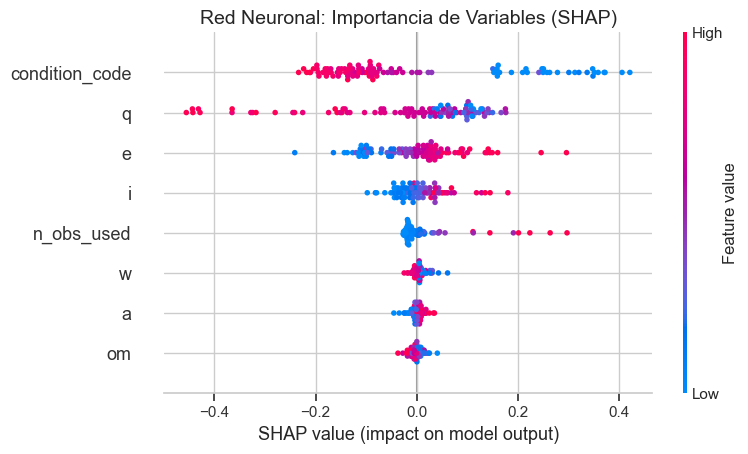

 Análisis de explicabilidad completado.


In [58]:
# ANÁLISIS EXPLICABILIDAD - RED NEURONAL (KERNEL EXPLAINER)
# Nota: KernelExplainer es computacionalmente intensivo, usamos una muestra reducida.

print("\n Calculando SHAP para Red Neuronal")

background = shap.sample(X_train_scaled, 50, random_state=42)
explainer_nn = shap.KernelExplainer(model_nn.predict, background)
shap_values_nn = explainer_nn.shap_values(X_test_scaled[:100], silent=True)

# Procesamiento de formato de salida SHAP (lista vs array)
if isinstance(shap_values_nn, list):
    shap_data_nn = shap_values_nn[0]
else:
    shap_data_nn = shap_values_nn
    
if len(shap_data_nn.shape) == 3:
    shap_data_nn = shap_data_nn[:, :, 0]

plt.figure(figsize=(10,6))
shap.summary_plot(shap_data_nn, X_test_scaled[:100], feature_names=features, show=False)
plt.title('Red Neuronal: Importancia de Variables (SHAP)', fontsize=14)
plt.tight_layout()
plt.show()

print(" Análisis de explicabilidad completado.")

## Simulación Operativa

Se realiza una simulación con 5 asteroides aleatorios, intentando recuperar el diámetro real o estimándolo si no está disponible, para contrastar con las predicciones del modelo.

In [59]:
import random
import math

def run_simulation():
    print("\n--- EVALUACIÓN FINAL: COMPARATIVA DE MODELOS Y PROPIEDADES FÍSICAS ---")
    print("Objetivo: Validación integral con datos físicos (Tamaño, MOID) y confianza por modelo.\n")
    
    # 1. Muestreo Estratificado
    dang_indices = y_test[y_test == 1].index.tolist()
    safe_indices = y_test[y_test == 0].index.tolist()
    
    sample_dang = random.sample(dang_indices, 5)
    sample_safe = random.sample(safe_indices, 5)
    simulation_indices = sample_dang + sample_safe
    random.shuffle(simulation_indices)
    
    results = []
    
    for idx in simulation_indices:
        # Recuperar datos de entrada (features)
        obj_data = X_test.loc[idx].values.reshape(1, -1)
        obj_data_scaled = scaler.transform(obj_data)
        
        # --- RECUPERACIÓN DE METADATA (Nombre y Diámetro) ---
        real_name = "Unknown"
        diameter_val = "N/A"
        
        # Intentar buscar en df_raw (dataset original sin procesar)
        try:
            row_raw = df_raw.loc[idx]
            real_name = row_raw['full_name']
            
            # Intentar obtener diámetro real si existe
            if 'diameter' in df_raw.columns and not pd.isna(row_raw['diameter']):
                d = float(row_raw['diameter'])
                diameter_val = f"{d:.3f} km"
            else:
                # Estimación basada en H (Albedo as 0.14)
                # En este notebook 'H' NO está en X_test, lo sacamos de df_proc
                h_val = df_proc.loc[idx]['H']
                est_diam = 1329 / (math.sqrt(0.14)) * (10 ** (-0.2 * h_val))
                diameter_val = f"~{est_diam:.3f} km*"
        except:
            # Fallback a df_proc o ID genérico
            try: real_name = df_proc.loc[idx]['full_name']
            except: real_name = f"ID_{idx}"
            
            # Estimación fallback
            h_val = df_proc.loc[idx]['H']
            est_diam = 1329 / (3.74) * (10 ** (-0.2 * h_val))
            diameter_val = f"~{est_diam:.3f} km*"
        
        # Predicciones
        p_rf = rf_model.predict_proba(obj_data_scaled)[0][1]
        p_nn = model_nn.predict(obj_data_scaled, verbose=0).flatten()[0]
        
        results.append({
            'Objeto': real_name,
            'MOID (AU)': f"{df_proc.loc[idx]['moid']:.4f}",
            'Mag (H)': f"{df_proc.loc[idx]['H']:.1f}",
            'Diámetro': diameter_val,
            'Realidad': 'PELIGRO' if y_test.loc[idx] == 1 else 'Seguro',
            'RF Pred': 'PELIGRO' if p_rf > 0.5 else 'Seguro',
            'RF Conf': f"{p_rf*100:.1f}%",
            'NN Pred': 'PELIGRO' if p_nn > 0.5 else 'Seguro',
            'NN Conf': f"{p_nn*100:.1f}%"
        })

    res_df = pd.DataFrame(results)
    
    def style_table(styler):
        styler.applymap(lambda v: 'color: red; font-weight: bold' if v == 'PELIGRO' else 'color: green', subset=['Realidad'])
        styler.applymap(lambda v: 'background-color: #ffcccc' if v == 'PELIGRO' else 'background-color: #ccffcc', subset=['RF Pred', 'NN Pred'])
        return styler
    
    try:
        display(style_table(res_df.style))
    except:
        display(res_df)
    
    print("\n* Diámetro estimado basado en Magnitud H (Albedo 0.14) cuando el dato real no está disponible.")
    print("MOID: Distancia Mínima de Intersección Orbital (Menor a 0.05 AU es potencialmente peligroso).")

run_simulation()


--- EVALUACIÓN FINAL: COMPARATIVA DE MODELOS Y PROPIEDADES FÍSICAS ---
Objetivo: Validación integral con datos físicos (Tamaño, MOID) y confianza por modelo.



c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2691: U

,Objeto,MOID (AU),Mag (H),Diámetro,Realidad,RF Pred,RF Conf,NN Pred,NN Conf
0,(2021 JE9),0.0196,24.5,~0.046 km*,Seguro,Seguro,0.1%,Seguro,3.8%
1,(2021 GH3),0.1867,22.7,~0.101 km*,Seguro,Seguro,0.0%,Seguro,0.0%
2,(2016 RN1),0.0360,21.0,~0.223 km*,PELIGRO,Seguro,47.9%,PELIGRO,79.4%
3,141525 (2002 FV5),0.0360,18.1,~0.864 km*,PELIGRO,PELIGRO,69.2%,PELIGRO,77.1%
4,(2018 BU),0.0469,25.9,~0.023 km*,Seguro,Seguro,0.0%,Seguro,0.1%
5,(2015 FL290),0.0086,22.2,~0.129 km*,Seguro,Seguro,13.0%,PELIGRO,80.1%
6,(2019 XE1),0.0188,19.7,~0.408 km*,PELIGRO,PELIGRO,50.3%,PELIGRO,76.5%
7,(2015 WG9),0.0291,20.4,~0.297 km*,PELIGRO,PELIGRO,68.9%,PELIGRO,73.5%
8,(2020 JV),0.0026,21.4,~0.186 km*,PELIGRO,PELIGRO,73.3%,PELIGRO,84.4%
9,(2017 WM15),0.0972,23.5,~0.071 km*,Seguro,Seguro,0.0%,Seguro,2.5%



* Diámetro estimado basado en Magnitud H (Albedo 0.14) cuando el dato real no está disponible.
MOID: Distancia Mínima de Intersección Orbital (Menor a 0.05 AU es potencialmente peligroso).
